# Comparing parameters across model sizes

# Setup

In [1]:
from safetensors import safe_open
import os
import glob
import numpy as np
import gc
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
model_paths = os.listdir('./llms')
model_paths

['Qwen2.5-3B', 'Qwen2.5-0.5B', 'Qwen2.5-7B', 'Qwen2.5-32B', 'Qwen2.5-14B']

In [3]:
# For lightweight testing
#model_paths = ['Qwen2.5-3B', 'Qwen2.5-0.5B']

In [4]:
model_safetensor_paths = {
    name: glob.glob(f'./llms/{name}/*.safetensors')
    for name in model_paths
}
model_safetensor_paths

{'Qwen2.5-3B': ['./llms/Qwen2.5-3B/model-00002-of-00002.safetensors',
  './llms/Qwen2.5-3B/model-00001-of-00002.safetensors'],
 'Qwen2.5-0.5B': ['./llms/Qwen2.5-0.5B/model.safetensors'],
 'Qwen2.5-7B': ['./llms/Qwen2.5-7B/model-00003-of-00004.safetensors',
  './llms/Qwen2.5-7B/model-00002-of-00004.safetensors',
  './llms/Qwen2.5-7B/model-00004-of-00004.safetensors',
  './llms/Qwen2.5-7B/model-00001-of-00004.safetensors'],
 'Qwen2.5-32B': ['./llms/Qwen2.5-32B/model-00012-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00007-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00001-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00011-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00006-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00004-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00016-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00008-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00015-of-00017.safetensors',
  './llms/Qwen2.5-32B/model-00009-of-00017.saf

In [5]:
def compute_tensor_statistic(stat_fn, name_condition = lambda x: True):
    statistics = {}
    for name, paths in model_safetensor_paths.items():
        statistics[name] = {}
        for path in paths:
            with safe_open(path, 'pt') as f:
                for k in f.keys():
                    if(name_condition(k)):
                        tensor = f.get_tensor(k)
                        statistics[name][k] = stat_fn(tensor)
                        del tensor
                        gc.collect()
    return statistics

In [6]:
def compute_array_statistic(stat_fn, name_condition = lambda x: True):
    statistics = {}
    for name, paths in model_safetensor_paths.items():
        statistics[name] = {}
        for path in paths:
            with safe_open(path, 'pt') as f:
                for k in f.keys():
                    if(name_condition(k)):
                        tensor = f.get_tensor(k).float().numpy()
                        statistics[name][k] = stat_fn(tensor)
                        del tensor
                        gc.collect()
    return statistics

# Computing Raw Statistics

## Computing sparsity
One easy way for us to be able to validate the distincion between our neural nets is to look at the sparsity of the attention. 

As models get larget they have larger context windows and therefore tend to have increasingly sparse attention matricies.

In [7]:
def compute_sparsity(tensor, threshold=1e-5):
    num_zero_elements = (np.abs(tensor) < threshold).sum()
    total_elements = tensor.size
    sparsity = num_zero_elements / total_elements
    return sparsity

In [8]:
query_sparsity = compute_tensor_statistic(
    lambda x: compute_sparsity(x.float().numpy()),
    lambda name: 'q_proj' in name and 'attn' in name and 'weight' in name
)

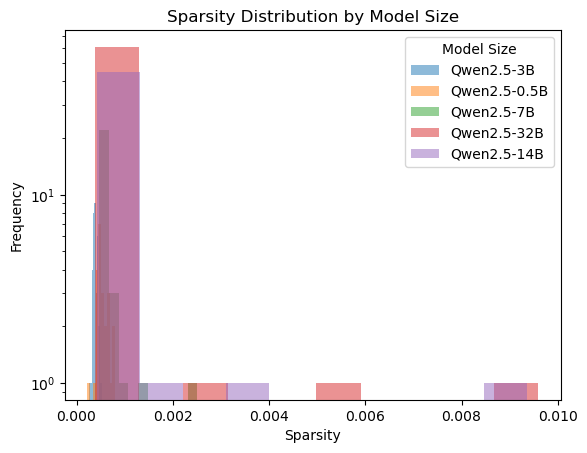

In [9]:
plt.figure()
for name, layers in query_sparsity.items():
    plt.hist(
        list(layers.values()),
        alpha=0.5,
        label=name
    )
plt.title("Sparsity Distribution by Model Size")
plt.xlabel("Sparsity")
plt.ylabel("Frequency")
plt.legend(title="Model Size")
plt.yscale('log')
plt.show()

In [10]:
key_sparsity = compute_tensor_statistic(
    lambda x: compute_sparsity(x.float().numpy()),
    lambda name: 'k_proj' in name and 'attn' in name and 'weight' in name
)

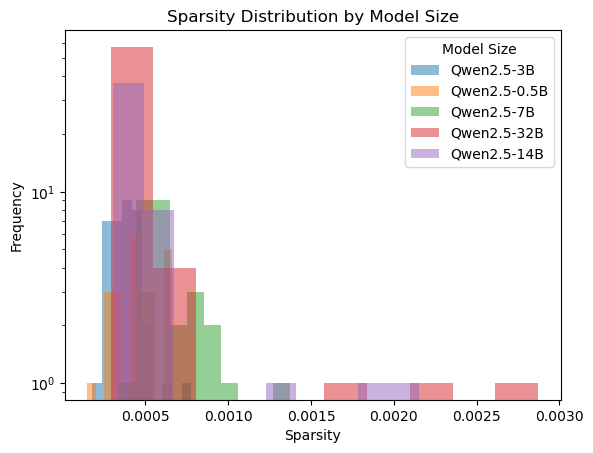

In [11]:
plt.figure()
for name, layers in key_sparsity.items():
    plt.hist(
        list(layers.values()),
        alpha=0.5,
        label=name
    )
plt.title("Sparsity Distribution by Model Size")
plt.xlabel("Sparsity")
plt.ylabel("Frequency")
plt.legend(title="Model Size")
plt.yscale('log')
plt.show()

In [12]:
value_sparsity = compute_tensor_statistic(
    lambda x: compute_sparsity(x.float().numpy()),
    lambda name: 'v_proj' in name and 'attn' in name and 'weight' in name
)

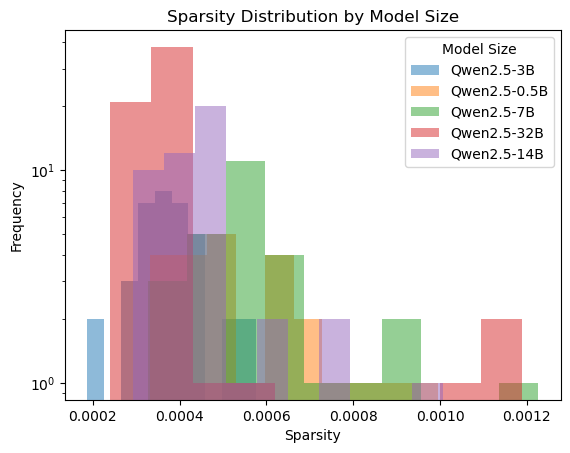

In [13]:
plt.figure()
for name, layers in value_sparsity.items():
    plt.hist(
        list(layers.values()),
        alpha=0.5,
        label=name
    )
plt.title("Sparsity Distribution by Model Size")
plt.xlabel("Sparsity")
plt.ylabel("Frequency")
plt.legend(title="Model Size")
plt.yscale('log')
plt.show()

In [14]:
layer_sparsity = compute_tensor_statistic(
    lambda x: compute_sparsity(x.float().numpy()),
    lambda name: 'attn' in name and 'weight' in name
)

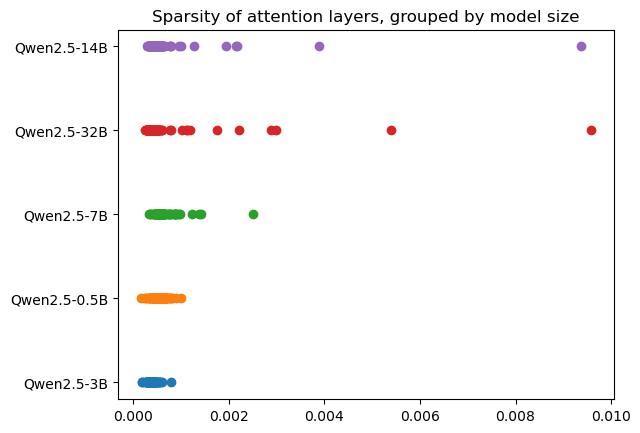

In [15]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(layer_sparsity.items()):
    
    ax.scatter(list(values.values()), [key] * len(values), label=key)
plt.title("Sparsity of attention layers, grouped by model size")
plt.show();

## Exploring outliers
We are interested in these extreme values, the so called `outliers` in these layers are representing the very specialized attention our tokens pay attention to one and other

### Computing max z score
With z score defined as $z_i=\frac{x_i-\mu}{\sigma}$ we can use this to gain a normalized understanding of how far outside the standard deviation our most extreme weights are

In [16]:
def compute_max_z_score(tensor):
    # Flatten the tensor to compute global statistics
    tensor = tensor.flatten()
    mean = np.mean(tensor)
    std = np.std(tensor)
    if std == 0:  # Handle edge case: all values are identical
        return 0
    z_scores = (tensor - mean) / std
    max_z_score = np.max(np.abs(z_scores))
    return max_z_score

In [17]:
attn_max_z_score = compute_tensor_statistic(
    lambda x: compute_max_z_score(x.float().numpy()),
    lambda name: 'attn' in name and 'weight' in name
)

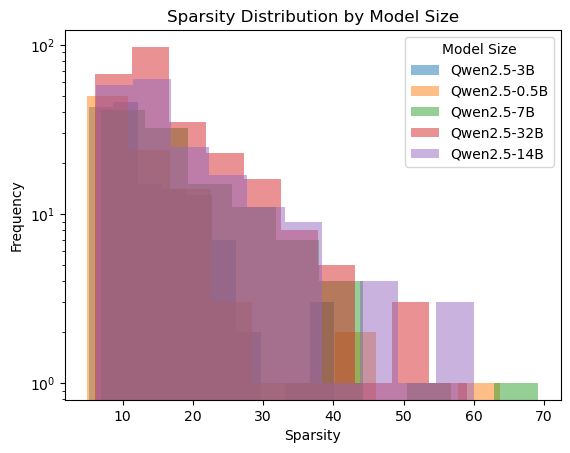

In [18]:
plt.figure()
for name, layers in attn_max_z_score.items():
    plt.hist(
        list(layers.values()),
        alpha=0.5,
        label=name
    )
plt.title("Sparsity Distribution by Model Size")
plt.xlabel("Sparsity")
plt.ylabel("Frequency")
plt.legend(title="Model Size")
plt.yscale('log')
plt.show()

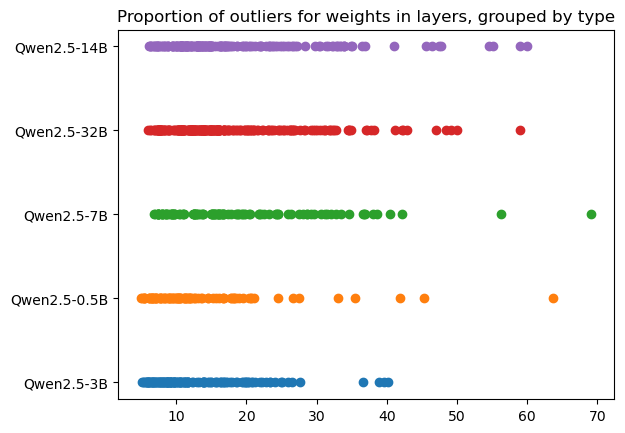

In [19]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(attn_max_z_score.items()):
    ax.scatter(list(values.values()), [key] * len(values), label=key)
plt.title("Proportion of outliers for weights in layers, grouped by type")
plt.show();

### Computing proportion of outliers above a given threshold
Say we want to compare the proportion of outliers outsize a certain number of standard deviations

How many of our outliers sit at these extreme of values. We can plot the number of outliers as our threshold increases to gain an understanding of this

In [20]:
def compute_proportion_above_threshold(tensor, threshold):
    # Flatten the tensor
    tensor = tensor.flatten()
    # Compute mean and standard deviation
    mean = np.mean(tensor)
    std = np.std(tensor)
    if std == 0:  # Handle edge case: all values are identical
        return 0.0
    # Compute Z-scores
    z_scores = (tensor - mean) / std
    # Count Z-scores above threshold
    num_above_threshold = (np.abs(z_scores) > threshold).sum()
    # Compute proportion
    proportion = num_above_threshold / len(z_scores)
    return proportion

In [21]:
over_threshold_series = {
    name: []
    for name in model_paths
}
thresholds = np.arange(0,5,.5)

for threshold in thresholds:
    prop_above = compute_array_statistic(
        lambda tensor: compute_proportion_above_threshold(tensor, threshold),
        lambda name: 'attn' in name and 'weight' in name
    )
    for name, layers in prop_above.items():
        over_threshold_series[name].append(np.mean(list(layers.values())))

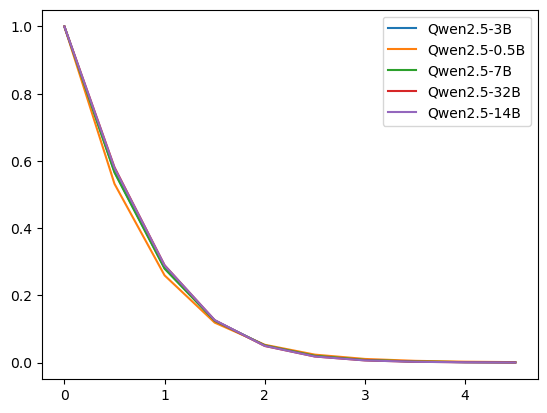

In [ ]:
plt.figure()
for name, average_proportions in over_threshold_series.items():
    plt.plot(thresholds, average_proportions, label=name)
plt.legend()
plt.show()

## Exploring attention variance
Larger models might have more focus on specific token to token attnetion making the variance lower

In [ ]:
layer_variance = compute_array_statistic(
    np.var,
    lambda name: 'attn' in name and 'weight' in name
)


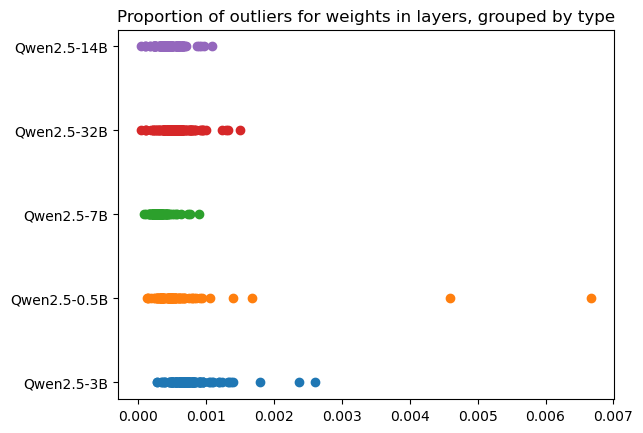

In [ ]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(layer_variance.items()):
    ax.scatter(list(values.values()), [key] * len(values), label=key)
plt.title("Proportion of outliers for weights in layers, grouped by type")
plt.show();

## Exploring entropy of attention distributions
More narrow attention would imply lower entropy
Entropy is calculated as $$H=-\sum_ip_i\log(p_i)$$

In [ ]:
def compute_entropy(tensor):
    probs = tensor / tensor.sum(axis=-1, keepdims=True)  
    probs = np.clip(probs, 1e-12, 1.0)  
    entropy = -np.sum(probs * np.log(probs), axis=-1)  
    return np.mean(entropy)  

In [ ]:
layer_entropy = compute_array_statistic(
    compute_entropy,
    lambda name: 'attn' in name and 'weight' in name
)

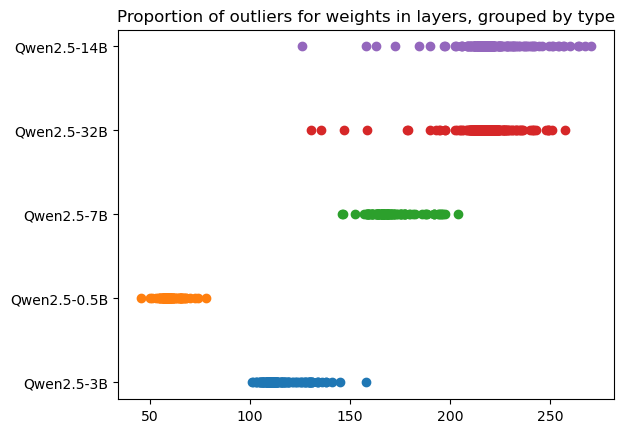

In [ ]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(layer_entropy.items()):
    ax.scatter(list(values.values()), [key] * len(values), label=key)
plt.title("Proportion of outliers for weights in layers, grouped by type")
plt.show();

## Exploring Rank
Rank can be calculated using a SVD
Larger models might have higher rank, showing less redundancy and more complex relationships

In [ ]:
def compute_rank_2d(matrix, threshold=1e-5):
    # Compute Singular Value Decomposition
    u, s, vh = np.linalg.svd(matrix, full_matrices=False)
    # Rank is the number of singular values above a threshold
    return np.mean(s)

In [ ]:
layer_rank = compute_array_statistic(
    compute_rank_2d,
    lambda name: 'attn' in name and 'weight' in name
)

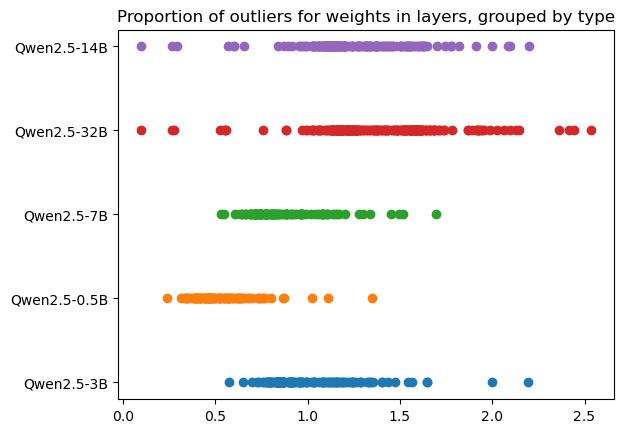

In [ ]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(layer_rank.items()):
    ax.scatter(list(values.values()), [key] * len(values), label=key)
plt.title("Proportion of outliers for weights in layers, grouped by type")
plt.show();

In [ ]:
layer_rank

{'Qwen2.5-3B': {'model.layers.22.self_attn.k_proj.weight': np.float32(1.0270312),
  'model.layers.22.self_attn.o_proj.weight': np.float32(0.8571906),
  'model.layers.22.self_attn.q_proj.weight': np.float32(0.8644582),
  'model.layers.22.self_attn.v_proj.weight': np.float32(1.1673498),
  'model.layers.23.self_attn.k_proj.weight': np.float32(1.2386231),
  'model.layers.23.self_attn.o_proj.weight': np.float32(0.77223766),
  'model.layers.23.self_attn.q_proj.weight': np.float32(0.8717622),
  'model.layers.23.self_attn.v_proj.weight': np.float32(1.0327103),
  'model.layers.24.self_attn.k_proj.weight': np.float32(1.0925539),
  'model.layers.24.self_attn.o_proj.weight': np.float32(0.8456316),
  'model.layers.24.self_attn.q_proj.weight': np.float32(0.8684877),
  'model.layers.24.self_attn.v_proj.weight': np.float32(1.1609268),
  'model.layers.25.self_attn.k_proj.weight': np.float32(0.83873284),
  'model.layers.25.self_attn.o_proj.weight': np.float32(0.8465097),
  'model.layers.25.self_attn.q_p

# ANOVA Test
Using this we can see if the means of our features are statistically significant given their distributions

### Setup
We should transform our data into a more easily workable format

In [ ]:
df_path = 'rank-and-enropy-by-size.csv'
if(os.path.exists(df_path)):
    df = pd.read_csv(df_path, header=0)

In [ ]:
df = []
for (name, entropies), ranks in zip(layer_entropy.items(), layer_rank.values()):
    for entropy, rank in zip(entropies.values(), ranks.values()):
        df.append([
            name, 
            entropy, 
            rank
        ])
df = pd.DataFrame(df, columns=['Size', 'Entropy', 'Rank'])

NameError: name 'layer_entropy' is not defined

In [ ]:
df.head()

,Size,Entropy,Rank
0,Qwen2.5-3B,106.084150,1.027031
1,Qwen2.5-3B,157.877600,0.857191
2,Qwen2.5-3B,110.908130,0.864458
3,Qwen2.5-3B,107.770065,1.167350
4,Qwen2.5-3B,113.449295,1.238623


In [ ]:
df.to_csv('rank-and-enropy-by-size.csv', index=False)

## Hypothesies:

$H_0$:

$H_A$:

## Checking Assumptions
In order to preform ANNOVA we need to make sure our data meets the following criterion:

1. Independece of Observations
2. Normality
3. Homogeneity of Variance
4. No Extreme Outliers

### Normality Assumption
ANNOVA assumes our distributions are drawn from a normally distributed population

In [ ]:
df_grouped = df.groupby('Size')

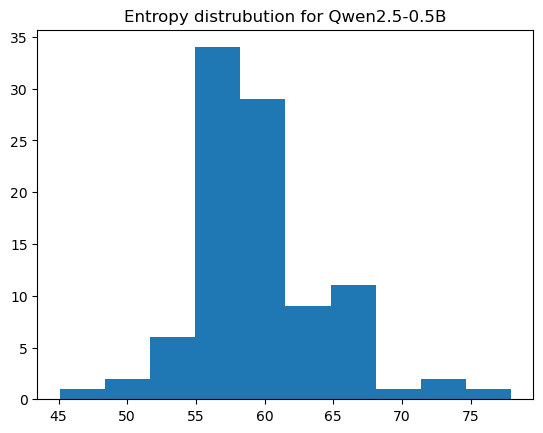

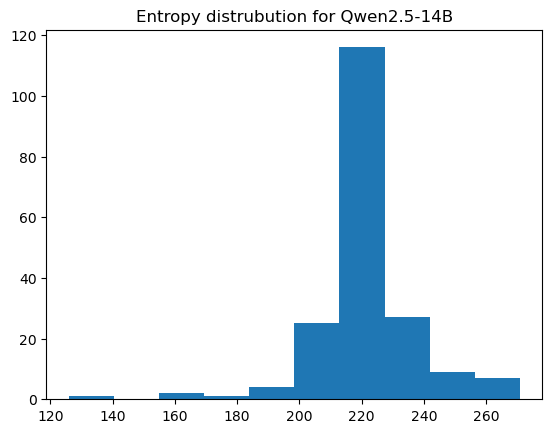

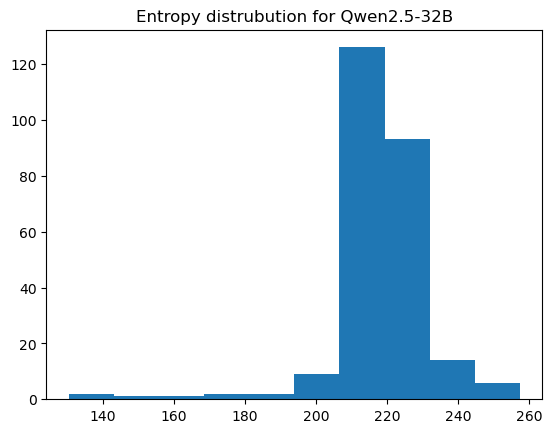

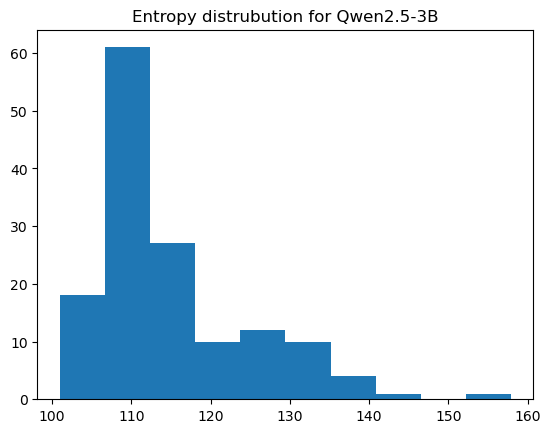

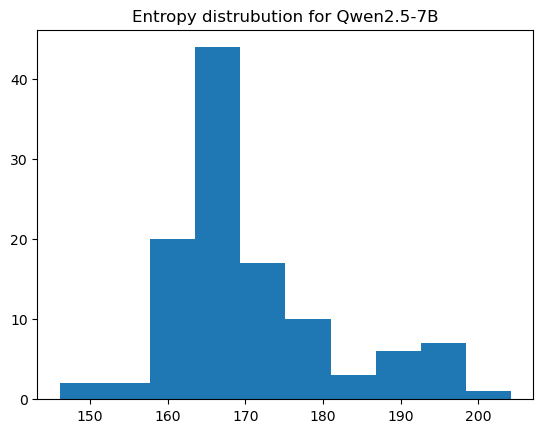

In [ ]:
for name, grouped_df in df_grouped:
    plt.figure()
    plt.hist(grouped_df['Entropy'])
    plt.title(f"Entropy distrubution for {name}")
    plt.show()

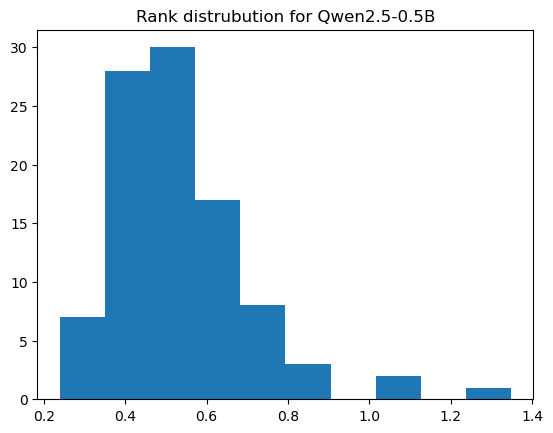

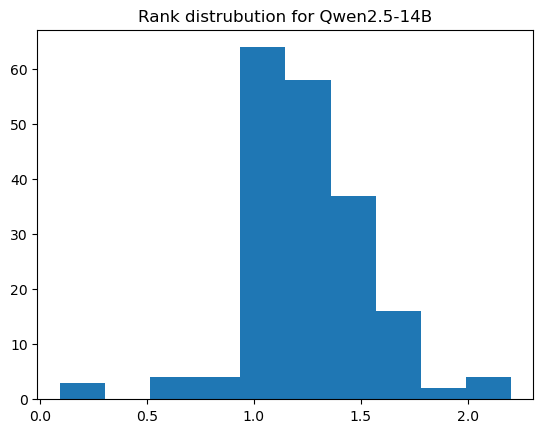

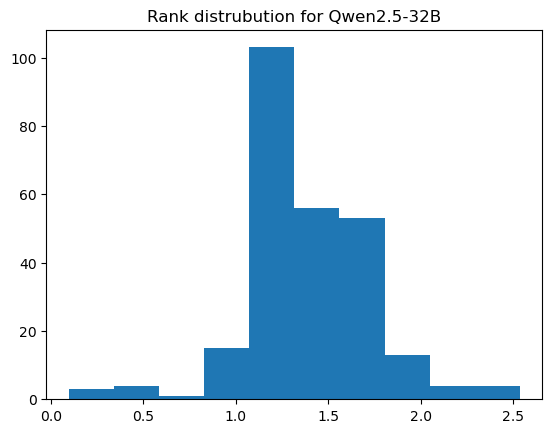

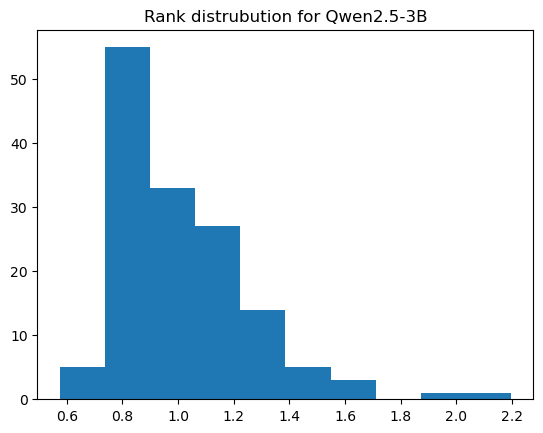

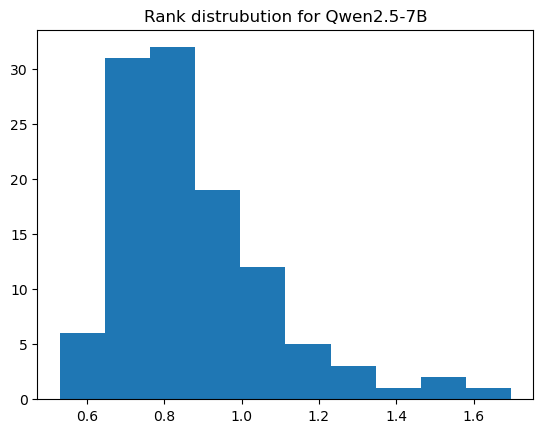

In [ ]:
for name, grouped_df in df_grouped:
    plt.figure()
    plt.hist(grouped_df['Rank'])
    plt.title(f"Rank distrubution for {name}")
    plt.show()

In [ ]:
from scipy.stats import shapiro

In [ ]:
{
    name: shapiro(list(group_df['Entropy']))
    for name, group_df in df_grouped
}

{'Qwen2.5-0.5B': ShapiroResult(statistic=np.float64(0.9250691880645655), pvalue=np.float64(3.773019450902122e-05)),
 'Qwen2.5-14B': ShapiroResult(statistic=np.float64(0.8306096368861098), pvalue=np.float64(1.116474911891986e-13)),
 'Qwen2.5-32B': ShapiroResult(statistic=np.float64(0.7309901791539464), pvalue=np.float64(4.359144656803541e-20)),
 'Qwen2.5-3B': ShapiroResult(statistic=np.float64(0.8614262367247841), pvalue=np.float64(2.6397735008615994e-10)),
 'Qwen2.5-7B': ShapiroResult(statistic=np.float64(0.9052363405991851), pvalue=np.float64(7.782121645859016e-07))}

In [ ]:
{
    name: shapiro(list(group_df['Rank']))
    for name, group_df in df_grouped
}

{'Qwen2.5-0.5B': ShapiroResult(statistic=np.float64(0.8669148873161042), pvalue=np.float64(8.484134582940793e-08)),
 'Qwen2.5-14B': ShapiroResult(statistic=np.float64(0.9315152661626723), pvalue=np.float64(7.4124919612584e-08)),
 'Qwen2.5-32B': ShapiroResult(statistic=np.float64(0.9381404460076164), pvalue=np.float64(6.733751505855825e-09)),
 'Qwen2.5-3B': ShapiroResult(statistic=np.float64(0.8659166578461369), pvalue=np.float64(4.2301384537438555e-10)),
 'Qwen2.5-7B': ShapiroResult(statistic=np.float64(0.882417966493884), pvalue=np.float64(6.270600317142751e-08))}

# Kruskal-Wallis H Test

## Hypothesis Tests

$H_0$: The medians of our categorical samples are not equal

$H_A$: The medians of our categorical samples are equal

## Assumptions
1. Independent Observations
2. Ordinal Dependent Variables
3. Two or more groups for our independent variables
4. Similar shapes of distribution

In [ ]:
from scipy.stats import kruskal

In [ ]:
kruskal(*[
    list(df_group['Entropy'])
    for name, df_group in df_grouped
])

KruskalResult(statistic=np.float64(641.1032472801858), pvalue=np.float64(1.9653929543101073e-137))

In [ ]:
kruskal(*[
    list(df_group['Rank'])
    for name, df_group in df_grouped
])

KruskalResult(statistic=np.float64(437.77261672421173), pvalue=np.float64(1.9102152249756624e-93))

# Permanova
https://onlinelibrary.wiley.com/doi/full/10.1002/9781118445112.stat07841

In [ ]:
from skbio.stats.distance import permanova, DistanceMatrix
dm = [
    [
        np.sqrt((rankA - rankB)**2 + (eucA - eucB)**2)
        for index, rankA, eucA in df[['Rank', 'Entropy']].itertuples()
    ]
    for index, rankB, eucB in df[['Rank', 'Entropy']].itertuples()
]
dm = DistanceMatrix(dm, df.index)
permanova(dm, df['Size'])

method name                 PERMANOVA
test statistic name          pseudo-F
sample size                       800
number of groups                    5
test statistic            4131.552506
p-value                         0.001
number of permutations            999
Name: PERMANOVA results, dtype: object